In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys
import os
import matplotlib.pyplot as plt
from matplotlib import rcParams
import yaml
import statsmodels.api as sm
import seaborn as sns
from scipy.interpolate import interp1d
import pickle
import numpy as np
sys.path.append('/home/xfang2/repos/celldetection')
import sma
from scipy.integrate import solve_ivp
import pandas as pd

In [2]:
# dydt function
def dydt(t,y,params):
    ATP,caIn=y
    
    caEx=params['caEx']
    kdecay=params['r']
    kflux=params['g']
    kleak=params['kleak']
    
    # ode
    dATPdt = -kdecay*ATP
    dcaIndt = caEx*kflux*ATP + kleak*(0.1-caIn)

    # the outputs (must be in the same order as ys above) 
    return [dATPdt,dcaIndt]

# normalization function
def minmax_scaling(data):
    data-=np.min(data)
    data/=np.max(data)
    
    return data

In [3]:
# reorder MC traces based on reference param
def reorder(df,ref_param=None,paramList=None,K=3,nChains=5):
    orders=[]
    reordered_vals=np.zeros((0,K))
    for chain in range(nChains):
        orders_chain=[]
        vals=[]
        for k in range(K):
            trace=df.loc[df['chain'] == chain, "('posterior', '{}[{}]', {})".format(ref_param,k,k)]
            vals.append(trace)
        vals=np.array(vals).T
        # reordering
        reordered=np.zeros_like(vals)
        for i in range(len(trace)):
            order = np.argsort(vals[i])
            reordered[i] = vals[i][order]
            orders_chain.append(order)
        orders.append(orders_chain)
        reordered_vals=np.append(reordered_vals,reordered,axis=0)
    for k in range(K):
        df['{}[{}]'.format(ref_param,k)]=reordered_vals[:,k]
    
    # apply reordering on other params
    for param in paramList:
        if param==ref_param:
            continue
        reordered_vals=np.zeros((0,K))
        for chain in range(nChains):
            vals=[]
            for k in range(K):
                trace=df.loc[df['chain'] == chain, "('posterior', '{}[{}]', {})".format(param,k,k)]
                vals.append(trace)
            vals=np.array(vals).T 
            # reordering
            reordered=np.zeros_like(vals)
            for i in range(len(trace)):
                order = orders[chain][i]
                reordered[i] = vals[i][order]
            reordered_vals=np.append(reordered_vals,reordered,axis=0)
        for k in range(K):
            df['{}[{}]'.format(param,k)]=reordered_vals[:,k]


In [4]:
## NOTE: initially some of the params were name differently
## r: kdecay, v: kclose, g: kflux
hypers_mu={
    'sim':{'mu_r': 4.0e-1, 'mu_g': 1.0e-1, 'mu_kleak': 5.5e-1},
    'expt':{'mu_r': 4.0e-2, 'mu_g': 5.0e-2, 'mu_kleak': 3.0e-1}}
hypers_sigma={
    'sim':{'mu_r': 1.0e-1, 'mu_g': 1.0e-1, 'mu_kleak': 1.0e-1},
    'expt':{'mu_r': 1.0e-1, 'mu_g': 1.0e-1, 'mu_kleak': 1.0e-1}}
fixedParams={'sim':{'caEx':1.0e1,'ATP':1.0},
            'expt':{'caEx':1.5,'ATP':1.0e-2}}
hyperParams=['mu_r','mu_g','mu_kleak']
params=['r','g','kleak']
paramList=['w','mu_r','mu_g','mu_kleak','sigma_r','sigma_g','sigma_kleak']
hyperLabels=['mu_k$_{decay}$', 'mu_k$_{flux}$', 'mu_k$_{leak}$']
labels=['k$_{decay}$', 'k$_{flux}$', 'k$_{leak}$']
cell_cols=['lightblue','paleturquoise','aqua','turquoise','mediumturquoise','mediumspringgreen','springgreen','palegreen','chartreuse','greenyellow','lime','limegreen']
k_cols=['lightskyblue','deepskyblue','royalblue']


In [6]:
# data to fit
exptFile='/home/xfang2/repos/bayes/data/observed_data/ca_uptake/expt_data.csv'
simFile='/home/xfang2/repos/bayes/data/observed_data/ca_uptake/sim_data.csv'
simData=np.genfromtxt(simFile, delimiter=',')  
exptData=np.genfromtxt(exptFile, delimiter=',')  
keys=['sim','expt']
frameRate={'sim':1.0,'expt':0.6} # sec/frame
nChains=5
normalize=True
K=3
nCells={'sim':simData.shape[1],'expt':exptData.shape[1]}
obs_data={}

for key in keys:
    file='/home/xfang2/repos/bayes/data/observed_data/ca_uptake/{}_data.csv'.format(key)
    raw_data=np.genfromtxt(file, delimiter=',')  
    dat=[]
    n=nCells[key]
    for cell in range(n):
        caExpt=raw_data[:,cell]
        dat.append(caExpt)
    obs_data[key]=dat
    

## analysis

In [ ]:
# load inference data
path='/home/xfang2/repos/bayes/data/inference_data/ca_uptake'
model=2
infData={}
infData['sim']=[]
infData['expt']=[]

file=path+'/model{}_trace_sim.csv'.format(model)
if os.path.isfile(file):
    df=pd.read_csv(file)
    reorder(df,ref_param='mu_r',paramList=paramList,K=3,nChains=5)
    infData['sim']=df
else:
    print('missing {}'.format(file))
file=path+'/model{}_trace_expt.csv'.format(model)
if os.path.isfile(file):
    df=pd.read_csv(file)
    reorder(df,ref_param='mu_r',paramList=paramList,K=3,nChains=5)
    infData['expt']=df
else:
    print('missing {}'.format(file))

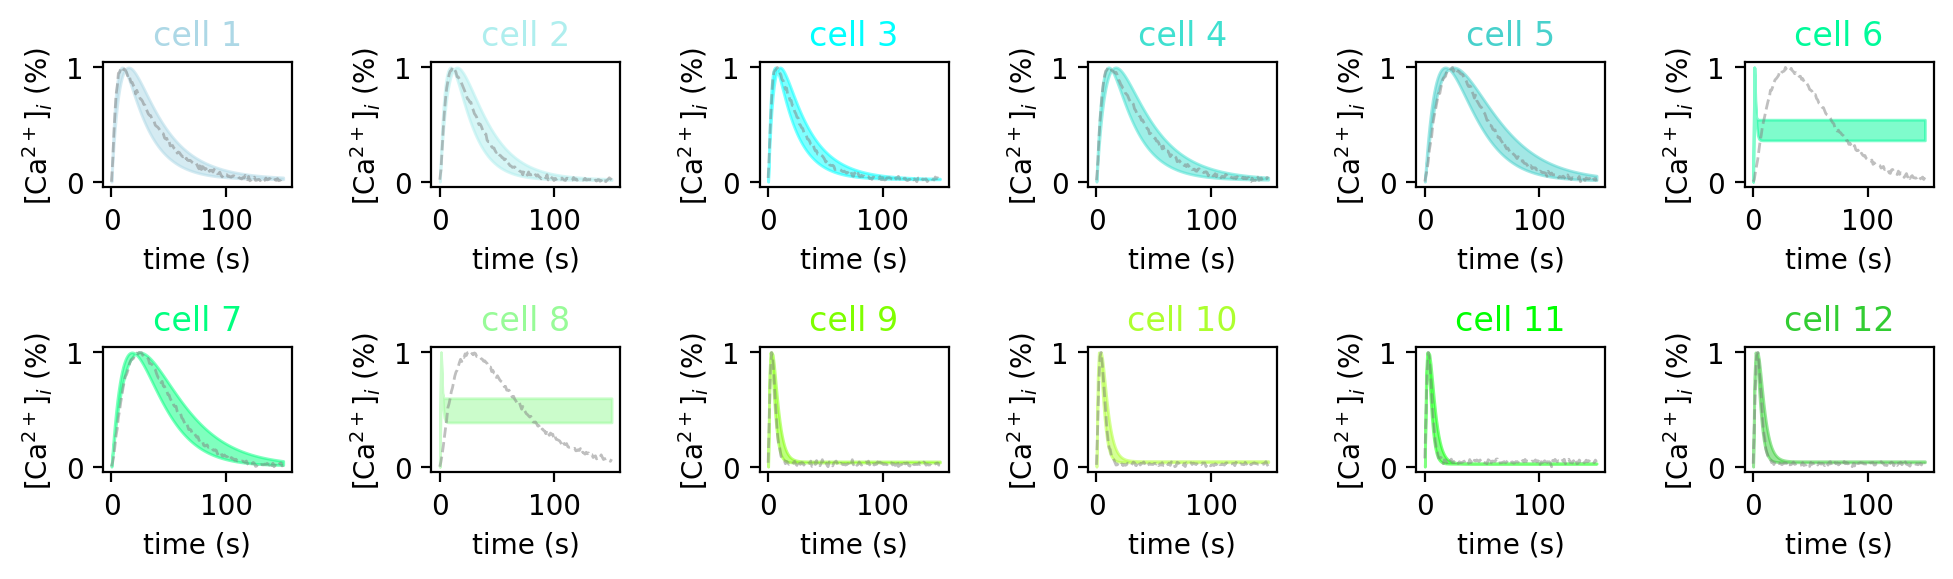

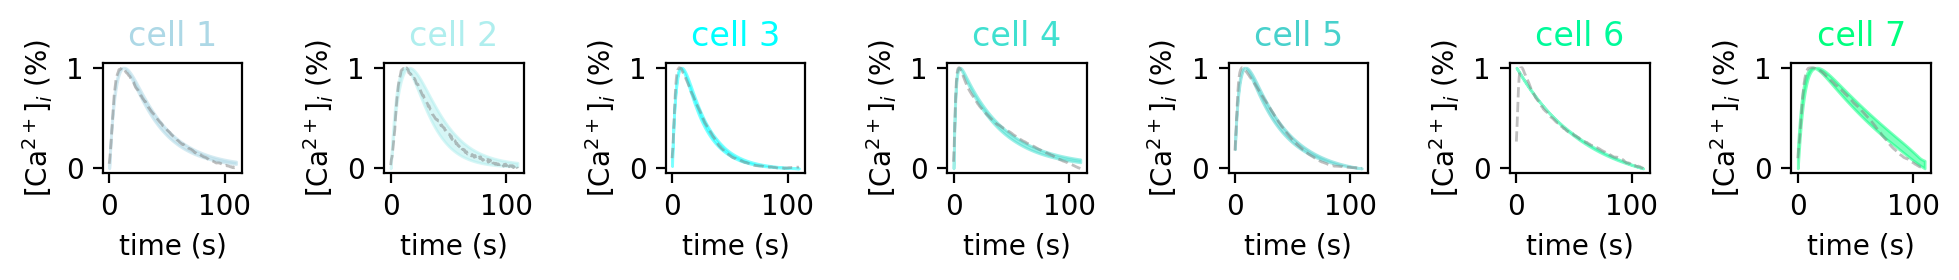

In [15]:
# fit
rcParams['font.size']=10
rcParams['figure.dpi']=200
for key in obs_data.keys():  
    if key=='expt':
        rcParams['figure.figsize']=10,1.5
    else:
        rcParams['figure.figsize']=10,3
        
    fig=plt.figure()
    n=nCells[key]
    df=infData[key]
    
    for cell in range(n):
        if key=='expt':            
            ax=fig.add_subplot(1,7,cell+1)
        else:
            ax=fig.add_subplot(2,6,cell+1)
        ax.set_title('cell {}'.format(cell+1),color=cell_cols[cell])
        ax.set_xlabel('time (s)')
        #ax.set_ylim([-0.2,1.2])
        #ax.set_yticks([0,0.5,1])
        #ax.set_xticks([0,50,100])
        ax.set_ylabel('[Ca$^{2+}$]$_i$ (%)')
        
        channel1=obs_data[key][cell]
        channel1=minmax_scaling(channel1)
        stepSize=len(channel1)
        ts=np.linspace(0,stepSize*frameRate[key],stepSize)
        ax.plot(ts,channel1,lw=1,color='gray',label='observed',alpha=0.5,linestyle='--')   

        channel1Min,channel1Max=np.min(channel1),np.max(channel1)
        y0=channel1[0]
        
        varDict,varDictLower,varDictUpper={},{},{}
        varDict['caEx'],varDictLower['caEx'],varDictUpper['caEx']=fixedParams[key]['caEx'],fixedParams[key]['caEx'],fixedParams[key]['caEx']
        for i,param in enumerate(params):
            vals=np.array([]) # array to combine all chains
            for chain in range(nChains):
                trace=df.loc[df['chain'] == chain, "('posterior', '{}[{}]', {})".format(param,cell,cell)]
                vals=np.append(vals,trace)
            N=len(vals)
            avg, lower, upper=np.mean(vals), np.sort(vals)[ int(0.05*N) ], np.sort(vals)[ int(0.95*N) ]
            varDict[param],varDictLower[param],varDictUpper[param]=avg,lower,upper

        if key == 'sim':
            y0s=[1.0, y0]
        else:
            y0s=[1.0e-2, y0]
        ys = solve_ivp(dydt,[0,ts[-1]],y0s,args=(varDict,),t_eval=ts,method='LSODA').y
        caSim=ys[1] 
        ys = solve_ivp(dydt,[0,ts[-1]],y0s,args=(varDictLower,),t_eval=ts,method='LSODA').y
        caSimLower=ys[1] 
        ys = solve_ivp(dydt,[0,ts[-1]],y0s,args=(varDictUpper,),t_eval=ts,method='LSODA').y
        caSimUpper=ys[1] 

        if chain == 0:
            print(key, cell, varDictLower,varDictUpper, '\n')

        # normalization
        caSim=minmax_scaling(caSim)
        caSimLower=minmax_scaling(caSimLower)
        caSimUpper=minmax_scaling(caSimUpper)

        # rescale
        caSim=caSim*(channel1Max-channel1Min)+channel1Min
        caSimLower=caSimLower*(channel1Max-channel1Min)+channel1Min
        caSimUpper=caSimUpper*(channel1Max-channel1Min)+channel1Min

        # area
        ax.fill_between(ts,caSimLower,caSimUpper,alpha=0.5,color=cell_cols[cell], label='95% CI')
    plt.tight_layout()
    plt.savefig('model{}_fit_{}.png'.format(model,key))


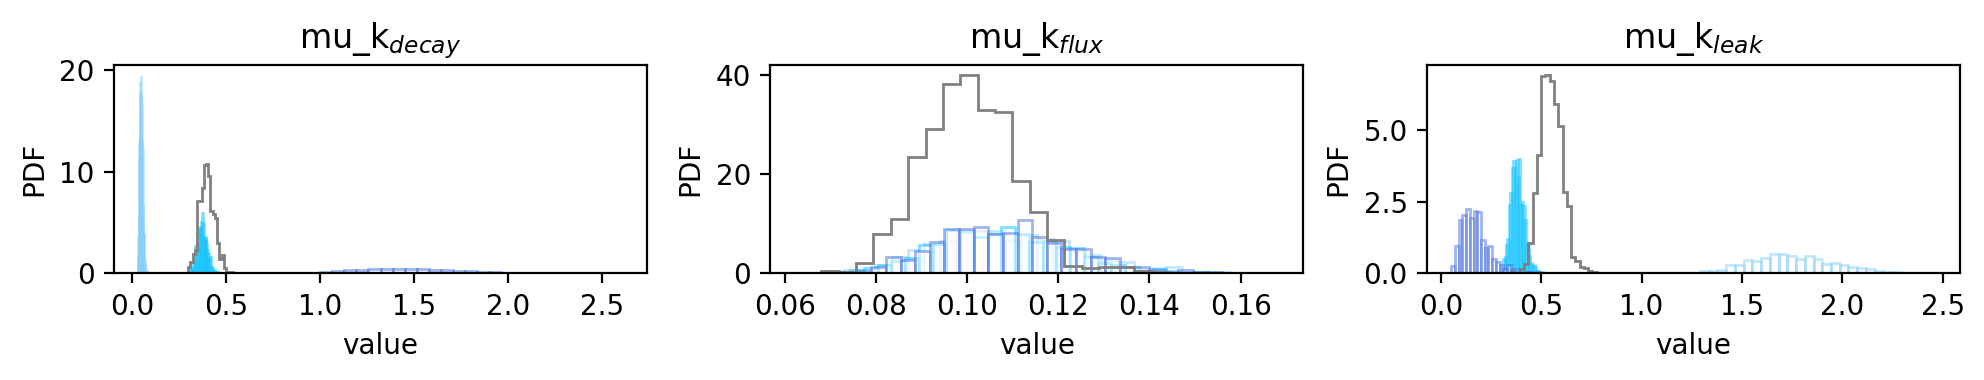

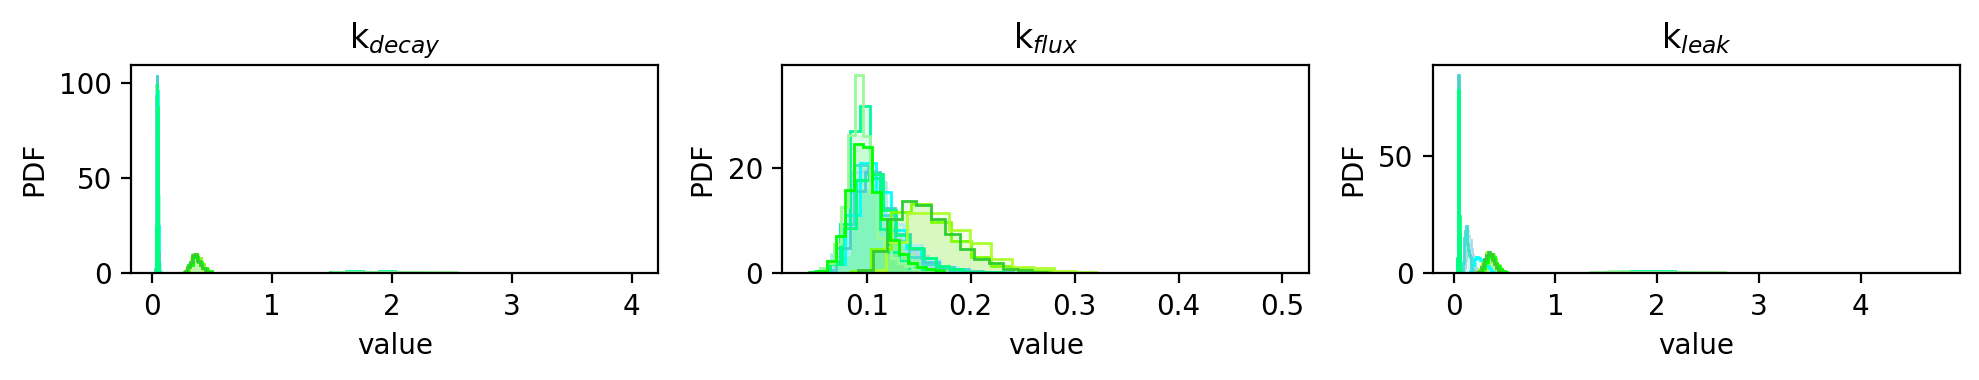

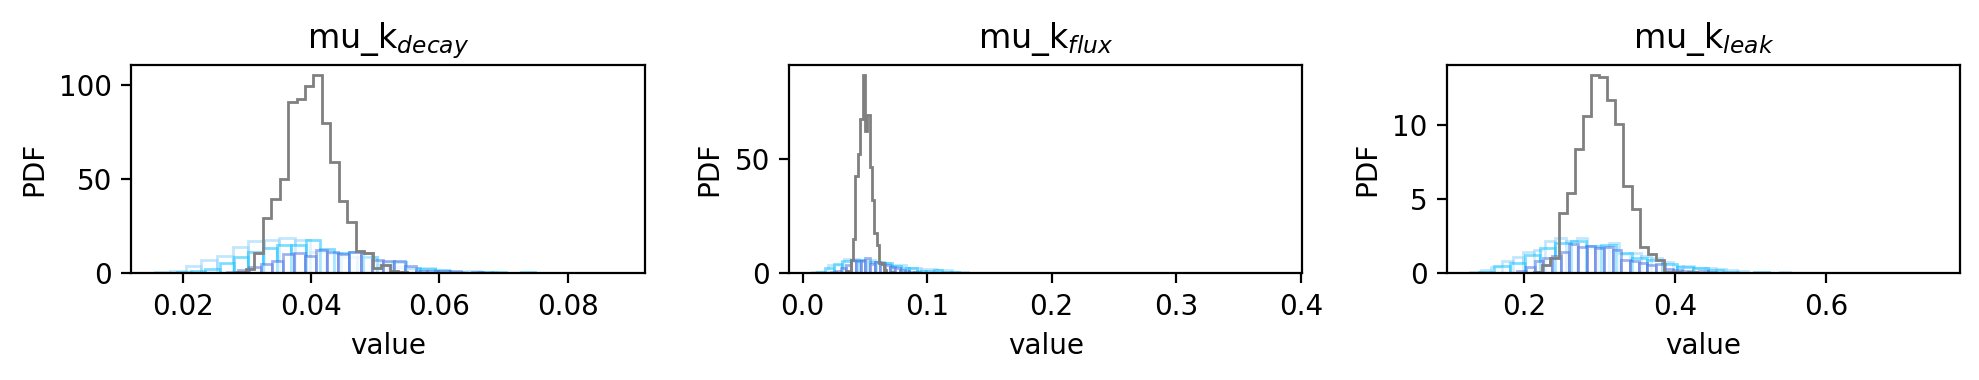

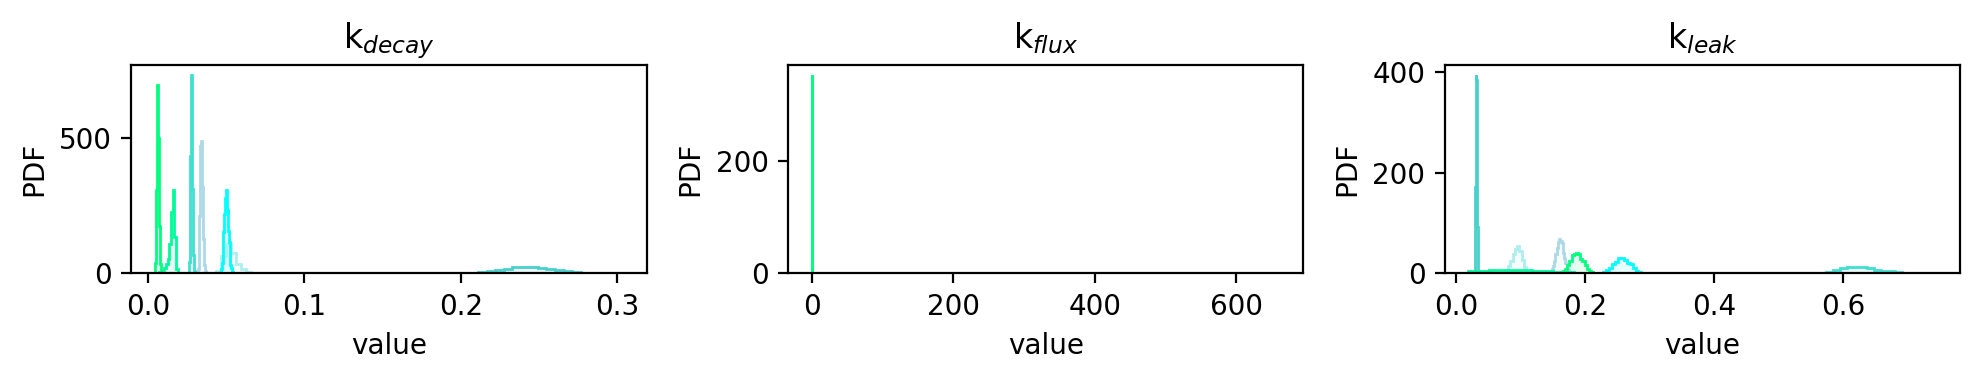

In [10]:
# posterior
rcParams['figure.dpi']=200
rcParams['font.size']=10

for key in obs_data.keys():
    df=infData[key]
    n=nCells[key]
    
    # hypers
    fig=plt.figure(figsize=(10,2))  
    for i,param in enumerate(params):    
        ax=fig.add_subplot(1,3,i+1)
        ax.set_title(hyperLabels[i])
        ax.set_xlabel('value')
        ax.set_ylabel('PDF')
        prs=[]
        for iteration in range(1000):
            pr=np.random.lognormal(mean=np.log(hypers_mu[key]['mu_{}'.format(param)]),sigma=hypers_sigma[key]['mu_{}'.format(param)])
            prs.append(pr)
        histPr=ax.hist(prs,bins=20,density=True,histtype='step',color='gray')      
        for k in range(K):
            mu_vals=np.array([])
            for chain in range(nChains):
                trace=df.loc[df['chain'] == chain, "mu_{}[{}]".format(param,k,k)]
                mu_vals=np.append(mu_vals,trace)
            w_vals=np.array([])
            for chain in range(nChains):
                trace=df.loc[df['chain'] == chain, "w[{}]".format(k)]
                w_vals=np.append(w_vals,trace)
            sigma_vals=np.array([])
            for chain in range(nChains):
                trace=df.loc[df['chain'] == chain, "sigma_{}[{}]".format(param,k,k)]
                sigma_vals=np.append(sigma_vals,trace)
            w=np.mean(w_vals)
            mu=np.mean(mu_vals)
            sigma=np.mean(sigma_vals)
            #ps=np.random.normal(mu,sigma,size=n)
            ps=np.random.lognormal(mean=np.log(mu),sigma=sigma,size=1000)
            nbin=30
            p,xs=np.histogram(ps,bins=nbin,density=True)
            new_p=p*w
            bin_widths = np.diff(xs)
            bin_centers = xs[:-1] + bin_widths / 2
            plt.bar(bin_centers, new_p, width=bin_widths, alpha=0.5, edgecolor=k_cols[k],color='white')
            
            
    plt.tight_layout()
    plt.savefig('model{}_posterior_{}_hyper.png'.format(model,key))
    
    # params
    fig=plt.figure(figsize=(10,2))  
    for i,param in enumerate(params):    
        ax=fig.add_subplot(1,3,i+1)
        ax.set_title(labels[i])
        ax.set_xlabel('value')
        ax.set_ylabel('PDF')

        for cell in range(n):
            #if key == 'sim' and param in truthVals.keys():
            #    ax.axvline(truthVals[param][cell],color=cols[cell],linestyle='--',alpha=0.5,lw=1)
            vals=np.array([])
            for chain in range(nChains):
                trace=df.loc[df['chain'] == chain, "('posterior', '{}[{}]', {})".format(param,cell,cell)]
                vals=np.append(vals,trace)
            ax.hist(vals,bins=20,color=cell_cols[cell],density=True,histtype='step')
            ax.hist(vals,bins=20,color=cell_cols[cell],alpha=0.1,density=True,histtype='stepfilled')
    plt.tight_layout()
    plt.savefig('model{}_posterior_{}.png'.format(model,key))



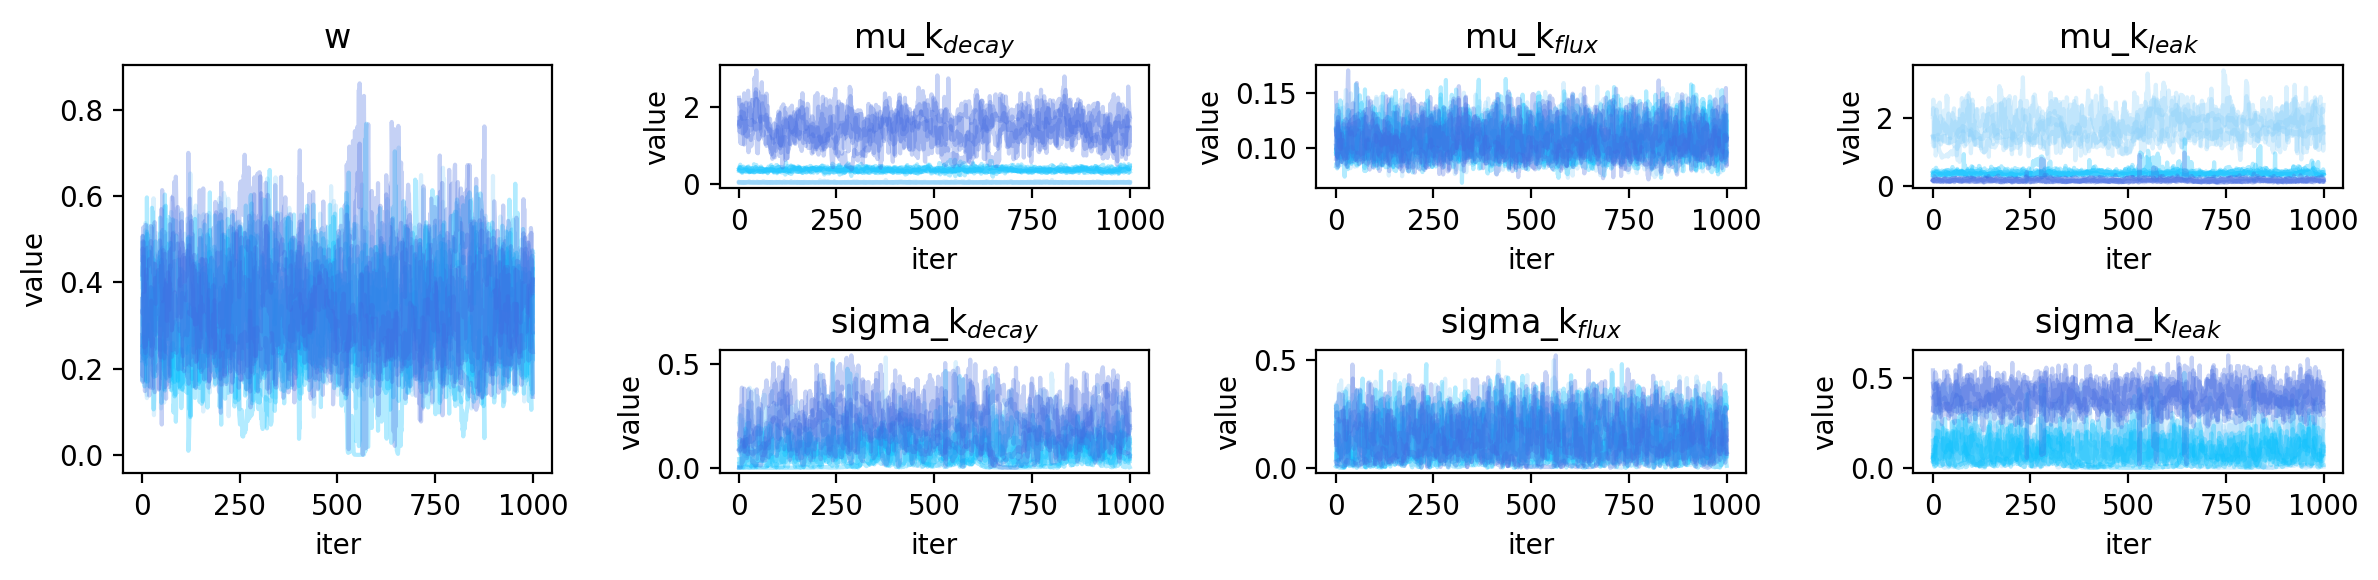

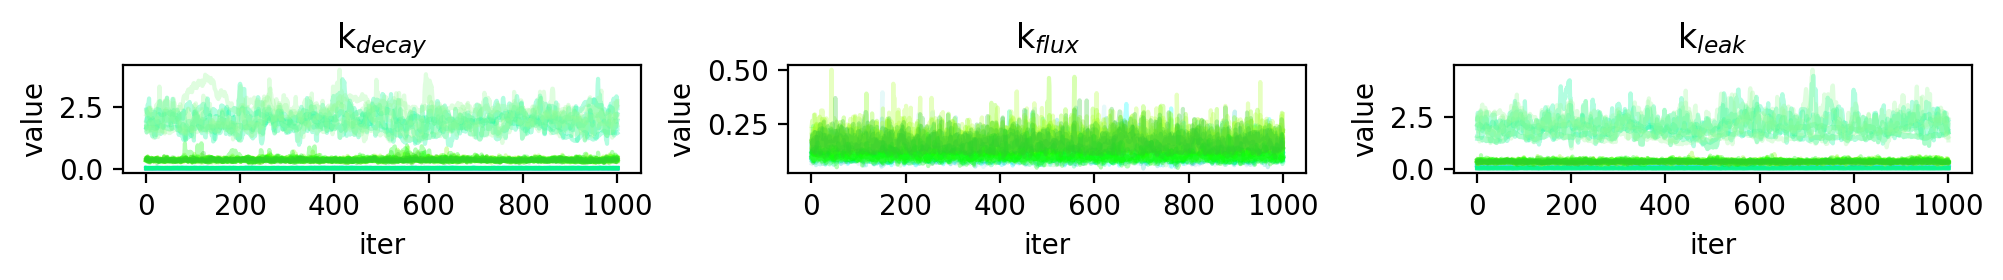

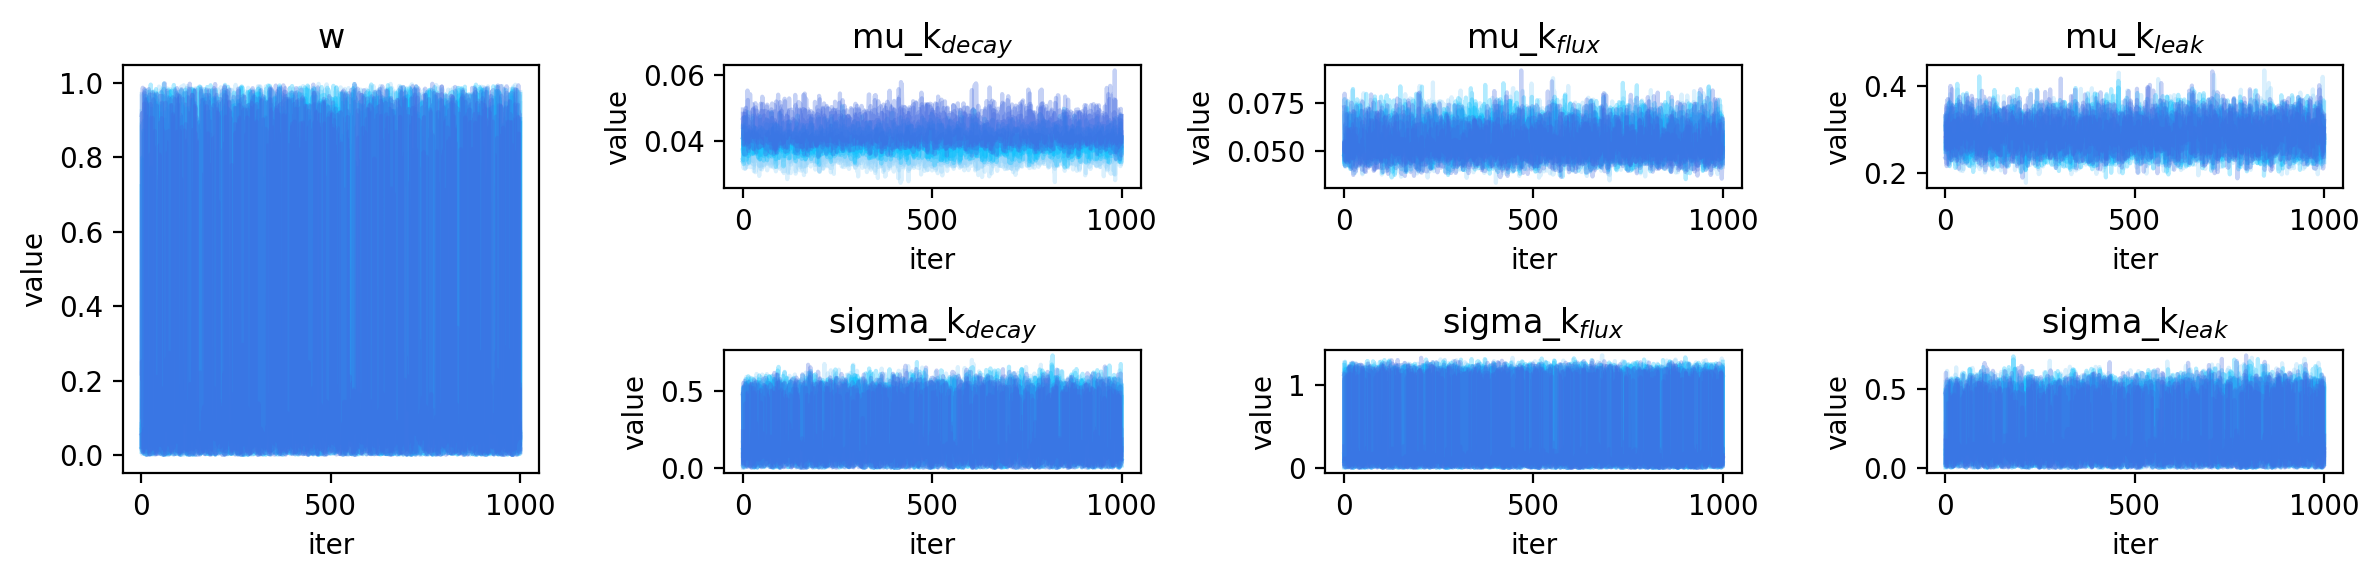

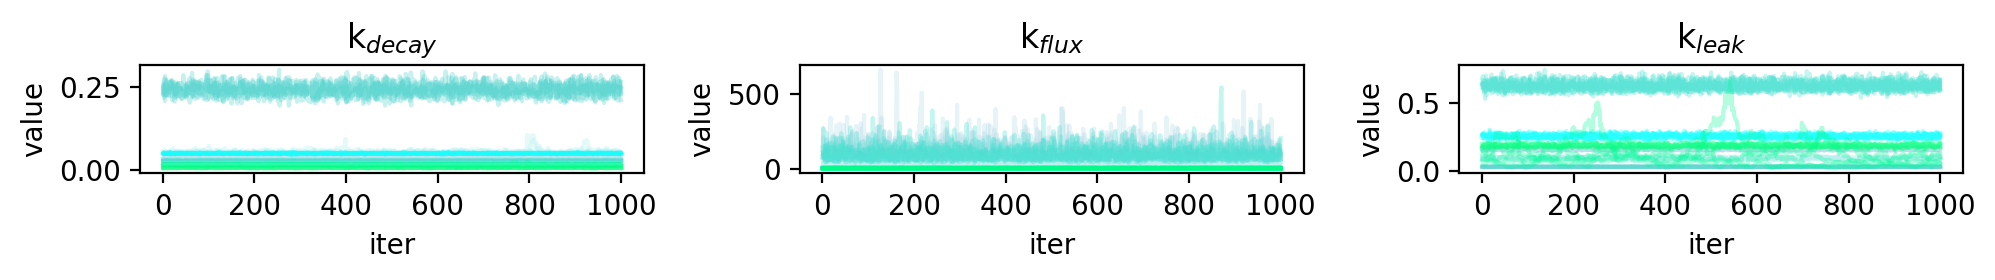

In [22]:
# trace plot
rcParams['figure.dpi']=200
rcParams['font.size']=10

for key in obs_data.keys():
    df=infData[key]
    n=nCells[key]
    
    # hypers
    fig=plt.figure(figsize=(12,3))
    
    ax=fig.add_subplot(1,4,1)
    ax.set_title('w')
    ax.set_xlabel('iter')
    ax.set_ylabel('value')

    for k in range(K):
        for chain in range(nChains):
            trace=df.loc[df['chain'] == chain, "w[{}]".format(k,k)]
            xs=range(1,len(trace)+1)
            ax.plot(xs,trace,color=k_cols[k],alpha=0.3)
                
    for i,param in enumerate(params):
        ax=fig.add_subplot(2,4,i+2)
        ax.set_title('mu_{}'.format(labels[i]))
        ax.set_xlabel('iter')
        ax.set_ylabel('value')

        for k in range(K):
            for chain in range(nChains):
                trace=df.loc[df['chain'] == chain, "mu_{}[{}]".format(param,k,k)]
                xs=range(1,len(trace)+1)
                ax.plot(xs,trace,color=k_cols[k],alpha=0.3)
    
    for i,param in enumerate(params):
        ax=fig.add_subplot(2,4,i+6)
        ax.set_title('sigma_{}'.format(labels[i]))
        ax.set_xlabel('iter')
        ax.set_ylabel('value')
        for k in range(K):
            for chain in range(nChains):
                trace=df.loc[df['chain'] == chain, "sigma_{}[{}]".format(param,k,k)]
                xs=range(1,len(trace)+1)
                ax.plot(xs,trace,color=k_cols[k],alpha=0.3)
    plt.tight_layout()
    plt.savefig('model{}_trace_{}_hyper.png'.format(model,key))
    
    # params
    fig=plt.figure(figsize=(10,1.5))
    for i,param in enumerate(params):
        ax=fig.add_subplot(1,3,i+1)
        ax.set_title(labels[i])
        ax.set_xlabel('iter')
        ax.set_ylabel('value')

        for cell in range(n):
            for chain in range(nChains):
                trace=df.loc[df['chain'] == chain, "('posterior', '{}[{}]', {})".format(param,cell,cell)]
                xs=range(1,len(trace)+1)
                ax.plot(xs,trace,color=cell_cols[cell],alpha=0.3)
    plt.tight_layout()
    plt.savefig('model{}_trace_{}.png'.format(model,key))

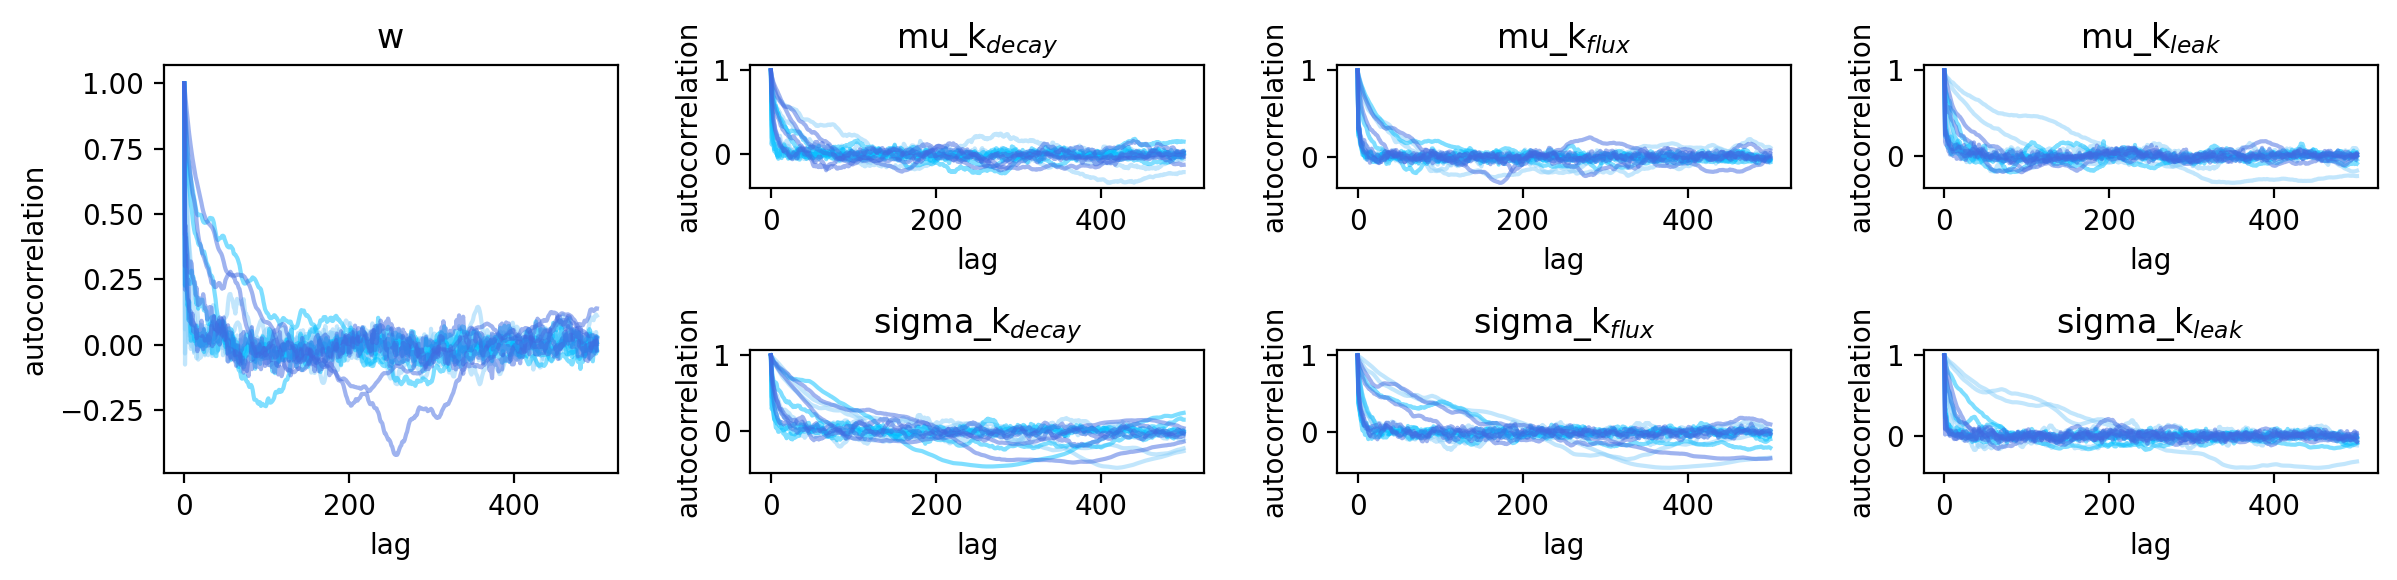

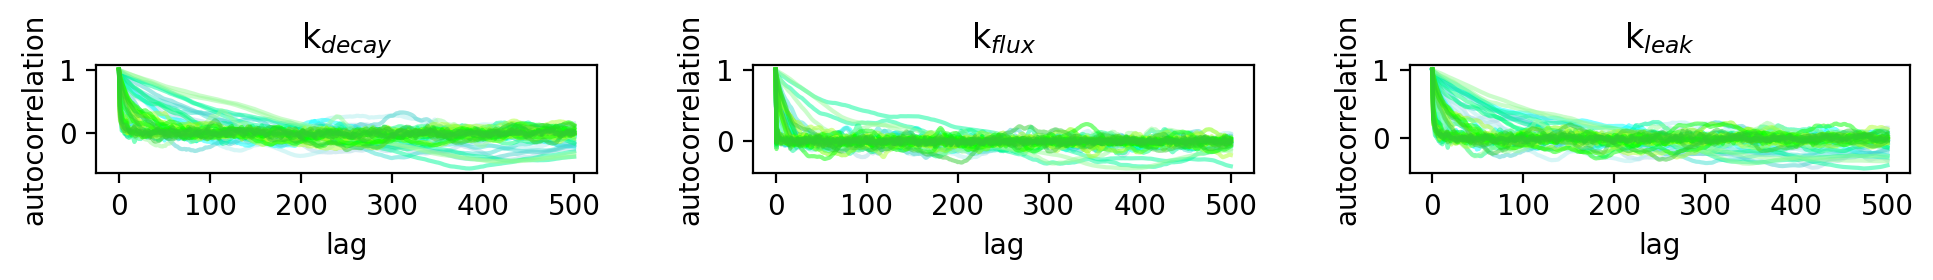

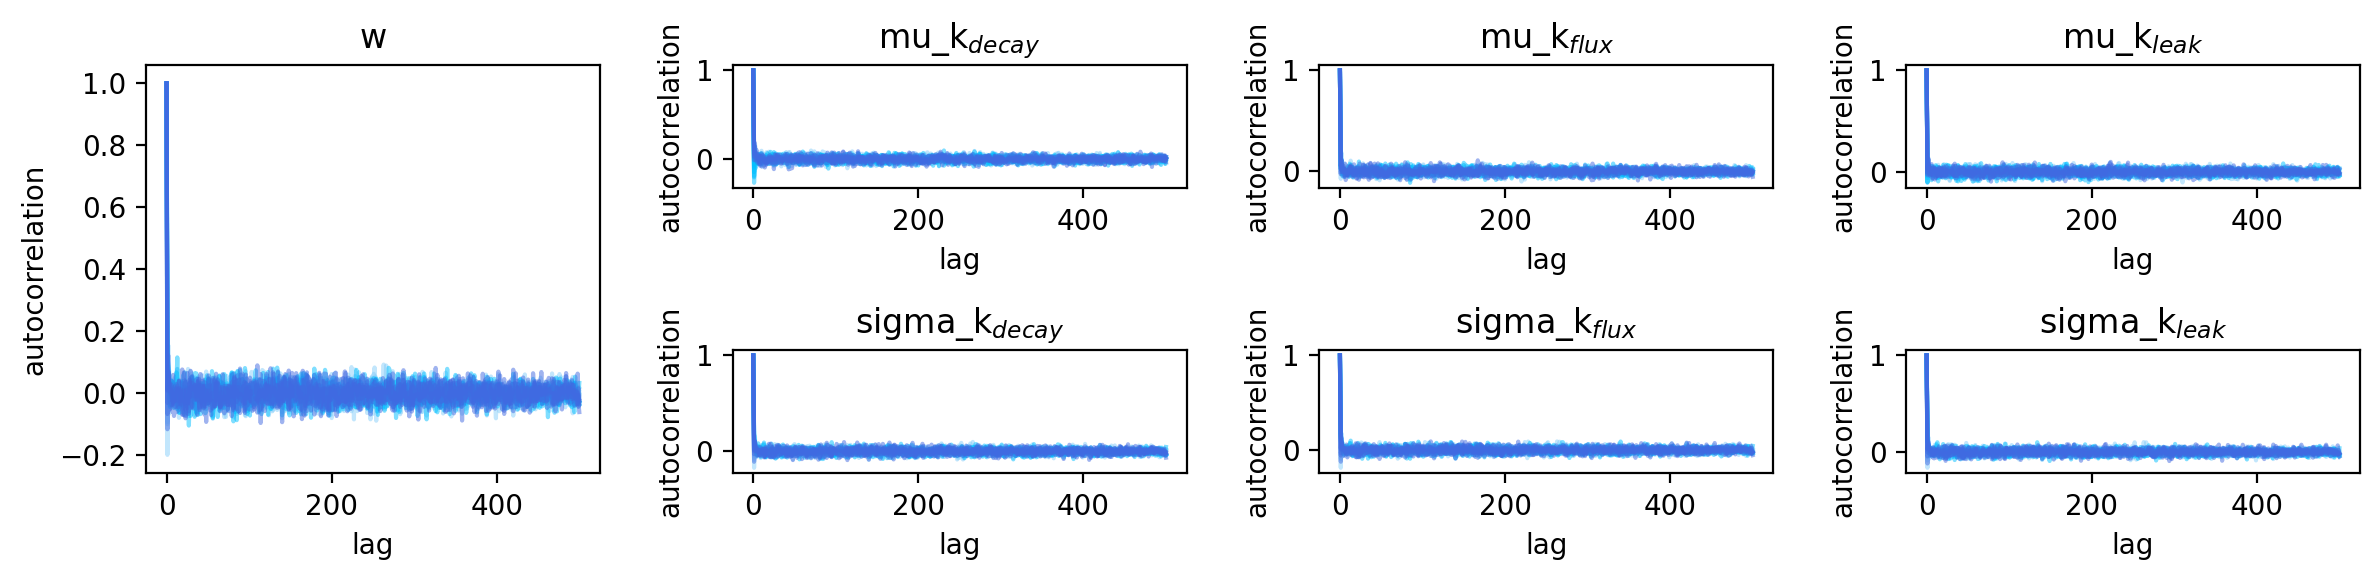

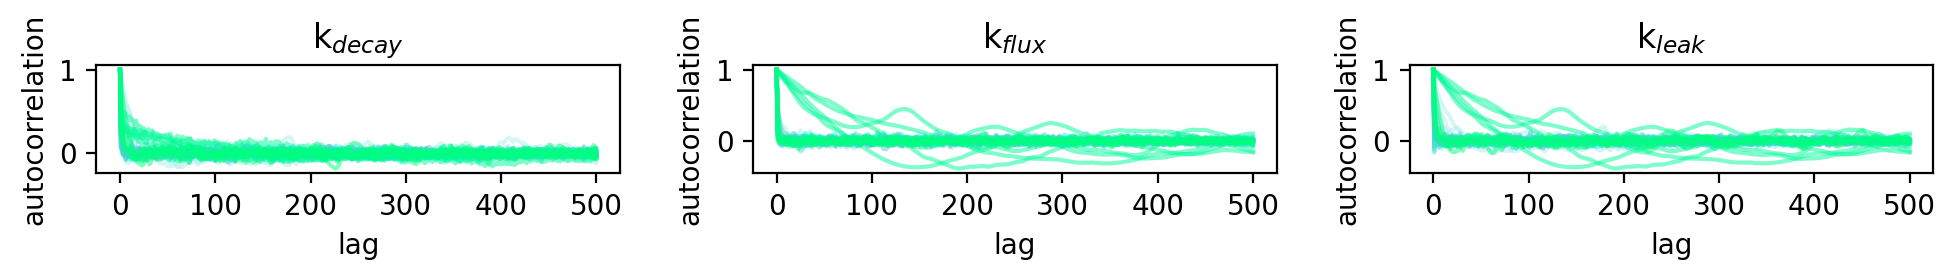

In [21]:
# autocorrelation
rcParams['figure.dpi']=200
rcParams['font.size']=10

for key in obs_data.keys():
    df=infData[key]
    n=nCells[key]
    
    fig=plt.figure(figsize=(12,3))  
    ax=fig.add_subplot(1,4,1)
    ax.set_title('w')
    ax.set_xlabel('lag')
    ax.set_ylabel('autocorrelation')    
    for k in range(K):
        for chain in range(nChains):
            trace=df.loc[df['chain'] == chain, "w[{}]".format(k,k)]
            autocorr = sm.tsa.acf(trace,nlags=500,fft=False)
            ax.plot(autocorr,color=k_cols[k],alpha=0.5)    
                
    for i,param in enumerate(params):    
        ax=fig.add_subplot(2,4,i+2)
        ax.set_title('mu_{}'.format(labels[i]))
        ax.set_xlabel('lag')
        ax.set_ylabel('autocorrelation')    
        for k in range(K):
            for chain in range(nChains):
                trace=df.loc[df['chain'] == chain, "mu_{}[{}]".format(param,k,k)]
                autocorr = sm.tsa.acf(trace,nlags=500,fft=False)
                ax.plot(autocorr,color=k_cols[k],alpha=0.5)     
    
    for i,param in enumerate(params):    
        ax=fig.add_subplot(2,4,i+6)
        ax.set_title('sigma_{}'.format(labels[i]))
        ax.set_xlabel('lag')
        ax.set_ylabel('autocorrelation')    
        for k in range(K):
            for chain in range(nChains):
                trace=df.loc[df['chain'] == chain, "sigma_{}[{}]".format(param,k,k)]
                autocorr = sm.tsa.acf(trace,nlags=500,fft=False)
                ax.plot(autocorr,color=k_cols[k],alpha=0.5)     
    plt.tight_layout()
    plt.savefig('model{}_autocorr_{}_hyper.png'.format(model,key))
    
    
    
    fig=plt.figure(figsize=(10,1.5))  
    for i,param in enumerate(params):    
        ax=fig.add_subplot(1,3,i+1)
        ax.set_title(labels[i])
        ax.set_xlabel('lag')
        ax.set_ylabel('autocorrelation')    

        for cell in range(n):
            for chain in range(nChains):
                trace=df.loc[df['chain'] == chain, "('posterior', '{}[{}]', {})".format(param,cell,cell)]
                autocorr = sm.tsa.acf(trace,nlags=500,fft=False)
                ax.plot(autocorr,color=cell_cols[cell],alpha=0.5)     
    plt.tight_layout()
    plt.savefig('model{}_autocorr_{}.png'.format(model,key))

In [19]:
# fit MSE
normalize=True
mses={'sim':[],
      'expt':[]}
nIter=500

for key in obs_data.keys():
    n=nCells[key]
    df=infData[key]
    
    for cell in range(n):
        mse1=[]
    
        channel1=obs_data[key][cell]
        channel1=minmax_scaling(channel1)
        stepSize=len(channel1)
        ts=np.linspace(0,stepSize*frameRate[key],stepSize)

        channel1Min,channel1Max=np.min(channel1),np.max(channel1)
        y0=channel1[0]
        
        varDict={}
        varDict['caEx']=fixedParams[key]['caEx']
        for j in range(nIter):
            for i,param in enumerate(params):
                vals=np.array([]) # array to combine all chains
                for chain in range(nChains):  
                    trace=df.loc[df['chain'] == chain, "('posterior', '{}[{}]', {})".format(param,cell,cell)]
                    vals=np.append(vals,trace)         
                vals_sorted=np.sort(vals)
                N=len(vals_sorted)
                vals_percentiled=vals_sorted[int(N*0.05):int(N*0.95)]
                draw=np.random.choice(vals_percentiled,size=1)
                varDict[param]=draw

            if key == 'sim':
                y0s=[1.0, y0]
            else:
                y0s=[1.0e-2, y0]
            ys = solve_ivp(dydt,[0,ts[-1]],y0s,args=(varDict,),t_eval=ts,method='LSODA').y
            sim1=ys[1] 

            # normalization
            sim1=minmax_scaling(sim1)

            # rescale
            sim1=sim1*(channel1Max-channel1Min)+channel1Min
            
            # MSE
            m1=np.mean((sim1-channel1)**2)
            mse1.append(m1)
    
        mses[key].append(mse1)

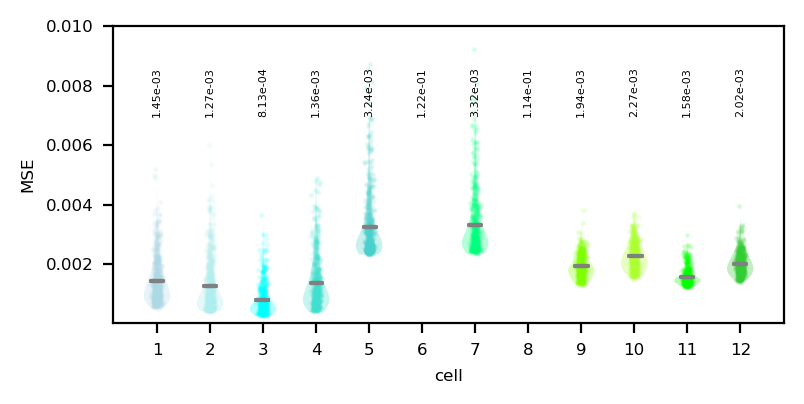

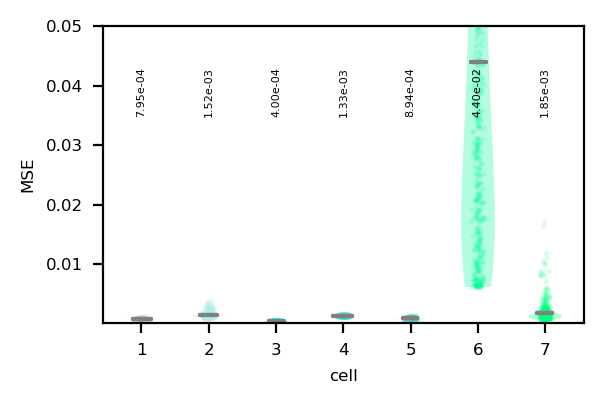

In [20]:

rcParams['font.size']=6
rcParams['figure.dpi']=200
#bootstrapping
nIter=500
nSample=20

for i,key1 in enumerate(mses.keys()):
    if key1=='sim':
        rcParams['figure.figsize']=4,2
    else:
        rcParams['figure.figsize']=3,2
    n=nCells[key1]
    
    fig=plt.figure()
    
    ax=fig.add_subplot(1,1,1)
    ax.set_xlabel('cell')
    ax.set_xticks(np.arange(n+1))
    ax.set_ylabel('MSE')
    if key1 == 'sim':
        ax.set_ylim([0.00001, 0.01])
        yloc=0.007
    else:
        ax.set_ylim([0.00002, 0.05])
        yloc=0.035

    vals=mses[key1]
    parts=ax.violinplot(vals,showextrema=False)
    for i,pc in enumerate(parts['bodies']):
        pc.set_facecolor(cell_cols[i])
        pc.set_alpha(0.3)
            
    for cell in range(n):
        ys=vals[cell]
        xs=np.random.normal(cell+1, 0.04, len(ys))
        ax.scatter(xs,ys,s=1,color=cell_cols[cell],alpha=0.1)

        # bootstrapping
        nData=len(ys)
        means=[]
        for k in range(nIter):
            draws=np.random.choice(ys,nSample)
            mean=np.mean(draws)
            means.append(mean)
        avg=np.mean(means)
        std=np.std(means)
        ax.plot(xs,np.repeat(avg,len(xs)),color='gray')
        ax.annotate(f"{avg:.2e}", xy=(cell+1, yloc),fontsize=4,
            horizontalalignment="center",rotation=90,
                   )

    plt.tight_layout()
    plt.gcf().savefig('model{}_mse_{}.png'.format(model,key1))